In [65]:
import glob
import os
import librosa
import numpy as np
import seaborn as sns
import wave
import contextlib
import pandas as pd

from sklearn.metrics import accuracy_score,classification_report,f1_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
%matplotlib inline
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

 # Features plots - Code

In [66]:
def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        X,sr = librosa.load(fp)
        raw_sounds.append(X)
    return raw_sounds

def plot_waves(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        librosa.display.waveplot(np.array(f),sr=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 1: Waveplot',x=0.5, y=0.915,fontsize=18)
    plt.show()
    
def plot_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        specgram(np.array(f), Fs=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 2: Spectrogram',x=0.5, y=0.915,fontsize=18)
    plt.show()

def plot_log_power_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        D = librosa.logamplitude(np.abs(librosa.stft(f))**2, ref_power=np.max)
        librosa.display.specshow(D,x_axis='time' ,y_axis='log')
        plt.title(n.title())
        i += 1
    plt.suptitle('Figure 3: Log power spectrogram',x=0.5, y=0.915,fontsize=18)
    plt.show()

# Extracting features

In [67]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    #print(chroma.shape)
    #print("chroma")
    #print(mfccs.shape)
    #print("mfccs")
    #print(mel.shape)
    #print("mels")
    #print(contrast.shape)
    #print("contrast")
    #print(tonnetz.shape)
    #print("tonnetz")    
    return mfccs,chroma,mel,contrast,tonnetz

def parse_audio_files(parent_dir,sub_dirs,file_ext='*.wav'):
    d=0
    duration1 = []
    duration2 = []
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir,sub_dir,file_ext)):
            with contextlib.closing(wave.open(fn,'r')) as f:
                frames = f.getnframes()
                rate = f.getframerate()
                duration = frames / float(rate)
                print(pd.Series(fn.split('_')).unique())
                print(d,duration)
                d=d+1
                print(" ")
                #dn=0
                if(sub_dir!='noise_set'):
                    #if(duration<0):
                    #    dn =dn+1
                    duration1.append(duration)  
                else:
                    duration2.append(duration)
            
    return duration1,duration2

In [68]:
def parse_audio_files2(parent_dir,sub_dirs,file_ext='*.wav'):
    features = np.empty((0,193))
    finlabel = np.empty((0,3))
    labells=[]
    labells1=np.empty(0) 
    labells2=np.empty(0) 
    d=0
    fns = []
    labels=[]
    label1s=[]
    label2s=[]
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir,sub_dir,file_ext)):
            mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
            ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
          #  print("ext_features")
          #  print(ext_features.shape)
            features = np.vstack([features,ext_features])
          #  print("features")
          #  print(features.shape)
            if(sub_dir!='noise_set'):
                    d = d+1
                    if (len(fn.split('_'))>=6):
                        label1 = "1"
                    else:
                        label1="0"
                    label="1"
                    if(sub_dir=='TRIM_old'):
                        if(fn.split('_')[-1]=='2.wav' ):
                            label2="2"
                        if(fn.split('_')[3]=='Multiplepeacock'):
                            label2 = "4"
                        else:
                            label2 ="1"
                    else:
                        if(fn.split('_')[-1]=='1.wav'):
                            label2="1"
                        elif(fn.split('_')[-1]=='2.wav'):
                            label2 ="2" 
                        elif(fn.split('_')[-1]=='3.wav'):
                            label2 ="3"
                        elif(fn.split('_')[-1]=='MI.wav' or fn.split('_')[-1]=='3or4.wav'):
                            label2 ="4"                        
                        else:
                            label2 ="0"
                            
            else:
                label ="0"
                label1="1"
                label2 ="0"
            fns.append(fn.split('_')[1:])
            use = np.hstack([label,label1,label2])
            finlabel = np.vstack([finlabel,use])
            labels.append(label)
            label1s.append(label1)
            label2s.append(label2)
    return(fns, np.array(features), np.array(finlabel),np.array(labels), np.array(label1s), np.array(label2s))

> #  Feed Train & Test Data 

In [69]:
parent_dir = '../input/data-w/data/data'

sub_dirs = ['C_new2','TRIM_old','A_new1','trimmed_new3','noise_set','Chincholi','iid','Kaan'] #train dirs
#sub_dirs2=['trimmed_new3','audio']        #test dirs

#features, labels,la1 , la2,la3 = 
duration1,duration2= parse_audio_files(parent_dir,sub_dirs)
#fea2,la2 = parse_audio_files(parent_dir,sub_dirs2)
#print(features)
#print(features.shape)
print('hiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii')
#print(labels)
#print(fea2)
#print(la2)

['../input/data-w/data/data/C' 'new2/03' 'SN' 'peacock' 'disturbance'
 '2.wav']
0 0.36378125
 
['../input/data-w/data/data/C' 'new2/12' ' Eow' 'peacock' '1.wav']
1 0.4250625
 
['../input/data-w/data/data/C' 'new2/17' 'Eow' 'peacock' 'disturbance'
 '2.wav']
2 7.5035625
 
['../input/data-w/data/data/C' 'new2/30' 'SN' 'peacock' '1.wav']
3 0.283375
 
['../input/data-w/data/data/C' 'new2/33' 'Eow' 'peacock' '1.wav']
4 0.60415625
 
['../input/data-w/data/data/C' 'new2/13' 'Eow' 'peacock' '1.wav']
5 8.26509375
 
['../input/data-w/data/data/C' 'new2/23' 'SN' 'peacock' 'disturbance'
 '2.wav']
6 0.36996875
 
['../input/data-w/data/data/C' 'new2/19' 'SN' 'peacock' '1.wav']
7 0.4014375
 
['../input/data-w/data/data/C' 'new2/34' 'Eow' 'peacock' 'disturbance'
 '2.wav']
8 0.680875
 
['../input/data-w/data/data/C' 'new2/27' 'SN' 'peacock' 'otherbird'
 '2.wav']
9 0.31878125
 
['../input/data-w/data/data/C' 'new2/06' 'SN' 'peacock' 'disturbance'
 '2.wav']
10 0.40828125
 
['../input/data-w/data/data/C' '

['../input/data-w/data/data/noise' 'set/2-121909-A-35.wav']
212 5.0
 
['../input/data-w/data/data/noise' 'set/3-100018-A-18.wav']
213 5.0
 
['../input/data-w/data/data/noise' 'set/5-103415-A-2.wav']
214 5.0
 
['../input/data-w/data/data/noise' 'set/5-171118-A-26.wav']
215 5.0
 
['../input/data-w/data/data/noise' 'set/4-182613-B-11.wav']
216 5.0
 
['../input/data-w/data/data/noise' 'set/1-17092-B-27.wav']
217 5.0
 
['../input/data-w/data/data/noise' 'set/1-69760-A-16.wav']
218 5.0
 
['../input/data-w/data/data/noise' 'set/5-204114-A-29.wav']
219 5.0
 
['../input/data-w/data/data/noise' 'set/2-121978-A-29.wav']
220 5.0
 
['../input/data-w/data/data/noise' 'set/5-198321-A-10.wav']
221 5.0
 
['../input/data-w/data/data/noise' 'set/3-140199-C-8.wav']
222 5.0
 
['../input/data-w/data/data/noise' 'set/4-164661-B-12.wav']
223 5.0
 
['../input/data-w/data/data/noise' 'set/2-99955-A-7.wav']
224 5.0
 
['../input/data-w/data/data/noise' 'set/4-155670-A-26.wav']
225 5.0
 
['../input/data-w/data/dat

['../input/data-w/data/data/noise' 'set/4-197871-A-15.wav']
349 5.0
 
['../input/data-w/data/data/noise' 'set/3-152912-A-26.wav']
350 5.0
 
['../input/data-w/data/data/noise' 'set/3-94344-A-25.wav']
351 5.0
 
['../input/data-w/data/data/noise' 'set/1-56233-A-9.wav']
352 5.0
 
['../input/data-w/data/data/noise' 'set/2-52085-B-4.wav']
353 5.0
 
['../input/data-w/data/data/noise' 'set/5-214362-A-17.wav']
354 5.0
 
['../input/data-w/data/data/noise' 'set/5-208810-B-11.wav']
355 5.0
 
['../input/data-w/data/data/noise' 'set/5-191131-A-40.wav']
356 5.0
 
['../input/data-w/data/data/noise' 'set/4-160036-A-33.wav']
357 5.0
 
['../input/data-w/data/data/noise' 'set/4-171706-A-23.wav']
358 5.0
 
['../input/data-w/data/data/noise' 'set/5-160551-A-42.wav']
359 5.0
 
['../input/data-w/data/data/noise' 'set/1-36164-B-26.wav']
360 5.0
 
['../input/data-w/data/data/noise' 'set/3-154758-A-44.wav']
361 5.0
 
['../input/data-w/data/data/noise' 'set/3-112397-A-9.wav']
362 5.0
 
['../input/data-w/data/data

['../input/data-w/data/data/noise' 'set/2-109371-A-16.wav']
485 5.0
 
['../input/data-w/data/data/noise' 'set/3-182710-B-35.wav']
486 5.0
 
['../input/data-w/data/data/noise' 'set/5-259169-A-5.wav']
487 5.0
 
['../input/data-w/data/data/noise' 'set/1-38559-A-14.wav']
488 5.0
 
['../input/data-w/data/data/noise' 'set/5-205589-A-17.wav']
489 5.0
 
['../input/data-w/data/data/noise' 'set/5-251963-A-47.wav']
490 5.0
 
['../input/data-w/data/data/noise' 'set/1-260640-B-2.wav']
491 5.0
 
['../input/data-w/data/data/noise' 'set/2-154688-A-31.wav']
492 5.0
 
['../input/data-w/data/data/noise' 'set/4-119647-C-48.wav']
493 5.0
 
['../input/data-w/data/data/noise' 'set/4-195451-A-44.wav']
494 5.0
 
['../input/data-w/data/data/noise' 'set/3-121348-A-9.wav']
495 5.0
 
['../input/data-w/data/data/noise' 'set/2-106849-A-47.wav']
496 5.0
 
['../input/data-w/data/data/noise' 'set/4-180380-A-10.wav']
497 5.0
 
['../input/data-w/data/data/noise' 'set/1-56234-A-9.wav']
498 5.0
 
['../input/data-w/data/dat

['../input/data-w/data/data/noise' 'set/2-110614-B-8.wav']
624 5.0
 
['../input/data-w/data/data/noise' 'set/1-31482-A-42.wav']
625 5.0
 
['../input/data-w/data/data/noise' 'set/5-188655-A-10.wav']
626 5.0
 
['../input/data-w/data/data/noise' 'set/5-216131-A-32.wav']
627 5.0
 
['../input/data-w/data/data/noise' 'set/1-23996-B-35.wav']
628 5.0
 
['../input/data-w/data/data/noise' 'set/3-165856-A-41.wav']
629 5.0
 
['../input/data-w/data/data/noise' 'set/1-50455-A-44.wav']
630 5.0
 
['../input/data-w/data/data/noise' 'set/4-132383-A-2.wav']
631 5.0
 
['../input/data-w/data/data/noise' 'set/1-100032-A-0.wav']
632 5.0
 
['../input/data-w/data/data/noise' 'set/1-23094-A-15.wav']
633 5.0
 
['../input/data-w/data/data/noise' 'set/1-96890-A-37.wav']
634 5.0
 
['../input/data-w/data/data/noise' 'set/3-132830-A-32.wav']
635 5.0
 
['../input/data-w/data/data/noise' 'set/3-171012-A-38.wav']
636 5.0
 
['../input/data-w/data/data/noise' 'set/5-200461-B-11.wav']
637 5.0
 
['../input/data-w/data/data/

['../input/data-w/data/data/noise' 'set/4-174860-B-3.wav']
760 5.0
 
['../input/data-w/data/data/noise' 'set/5-233787-A-7.wav']
761 5.0
 
['../input/data-w/data/data/noise' 'set/3-151080-A-20.wav']
762 5.0
 
['../input/data-w/data/data/noise' 'set/4-250869-B-2.wav']
763 5.0
 
['../input/data-w/data/data/noise' 'set/2-87781-A-10.wav']
764 5.0
 
['../input/data-w/data/data/noise' 'set/1-977-A-39.wav']
765 5.0
 
['../input/data-w/data/data/noise' 'set/4-181286-A-10.wav']
766 5.0
 
['../input/data-w/data/data/noise' 'set/5-212736-A-17.wav']
767 5.0
 
['../input/data-w/data/data/noise' 'set/2-120218-B-30.wav']
768 5.0
 
['../input/data-w/data/data/noise' 'set/3-203371-A-39.wav']
769 5.0
 
['../input/data-w/data/data/noise' 'set/4-172500-A-27.wav']
770 5.0
 
['../input/data-w/data/data/noise' 'set/3-62878-A-42.wav']
771 5.0
 
['../input/data-w/data/data/noise' 'set/5-184323-A-42.wav']
772 5.0
 
['../input/data-w/data/data/noise' 'set/4-187504-A-17.wav']
773 5.0
 
['../input/data-w/data/data/

['../input/data-w/data/data/noise' 'set/2-37806-B-40.wav']
898 5.0
 
['../input/data-w/data/data/noise' 'set/4-150364-A-46.wav']
899 5.0
 
['../input/data-w/data/data/noise' 'set/3-126113-A-26.wav']
900 5.0
 
['../input/data-w/data/data/noise' 'set/3-178096-A-6.wav']
901 5.0
 
['../input/data-w/data/data/noise' 'set/2-99796-A-32.wav']
902 5.0
 
['../input/data-w/data/data/noise' 'set/3-148330-A-21.wav']
903 5.0
 
['../input/data-w/data/data/noise' 'set/3-71964-C-4.wav']
904 5.0
 
['../input/data-w/data/data/noise' 'set/2-50666-A-20.wav']
905 5.0
 
['../input/data-w/data/data/noise' 'set/5-203739-A-10.wav']
906 5.0
 
['../input/data-w/data/data/noise' 'set/5-220955-A-40.wav']
907 5.0
 
['../input/data-w/data/data/noise' 'set/4-99193-A-4.wav']
908 5.0
 
['../input/data-w/data/data/noise' 'set/3-127890-B-9.wav']
909 5.0
 
['../input/data-w/data/data/noise' 'set/2-104475-A-37.wav']
910 5.0
 
['../input/data-w/data/data/noise' 'set/5-150409-A-42.wav']
911 5.0
 
['../input/data-w/data/data/n

1037 5.0
 
['../input/data-w/data/data/noise' 'set/5-187201-A-4.wav']
1038 5.0
 
['../input/data-w/data/data/noise' 'set/2-39945-A-19.wav']
1039 5.0
 
['../input/data-w/data/data/noise' 'set/4-168446-A-45.wav']
1040 5.0
 
['../input/data-w/data/data/noise' 'set/4-149294-B-41.wav']
1041 5.0
 
['../input/data-w/data/data/noise' 'set/3-172922-A-48.wav']
1042 5.0
 
['../input/data-w/data/data/noise' 'set/1-79113-A-5.wav']
1043 5.0
 
['../input/data-w/data/data/noise' 'set/1-54065-B-45.wav']
1044 5.0
 
['../input/data-w/data/data/noise' 'set/1-38560-A-14.wav']
1045 5.0
 
['../input/data-w/data/data/noise' 'set/5-243459-B-14.wav']
1046 5.0
 
['../input/data-w/data/data/noise' 'set/2-50665-A-20.wav']
1047 5.0
 
['../input/data-w/data/data/noise' 'set/5-232272-A-44.wav']
1048 5.0
 
['../input/data-w/data/data/noise' 'set/5-235671-A-38.wav']
1049 5.0
 
['../input/data-w/data/data/noise' 'set/4-90014-B-42.wav']
1050 5.0
 
['../input/data-w/data/data/noise' 'set/1-75190-A-8.wav']
1051 5.0
 
['../

['../input/data-w/data/data/noise' 'set/1-47709-A-16.wav']
1176 5.0
 
['../input/data-w/data/data/noise' 'set/2-59321-A-49.wav']
1177 5.0
 
['../input/data-w/data/data/noise' 'set/2-250710-A-39.wav']
1178 5.0
 
['../input/data-w/data/data/noise' 'set/3-143119-A-21.wav']
1179 5.0
 
['../input/data-w/data/data/noise' 'set/5-205090-A-32.wav']
1180 5.0
 
['../input/data-w/data/data/noise' 'set/1-26143-A-21.wav']
1181 5.0
 
['../input/data-w/data/data/noise' 'set/5-215005-A-32.wav']
1182 5.0
 
['../input/data-w/data/data/noise' 'set/3-107219-A-1.wav']
1183 5.0
 
['../input/data-w/data/data/noise' 'set/3-140199-B-8.wav']
1184 5.0
 
['../input/data-w/data/data/noise' 'set/3-182025-A-30.wav']
1185 5.0
 
['../input/data-w/data/data/noise' 'set/4-170247-A-12.wav']
1186 5.0
 
['../input/data-w/data/data/noise' 'set/1-21935-A-38.wav']
1187 5.0
 
['../input/data-w/data/data/noise' 'set/4-218199-C-35.wav']
1188 5.0
 
['../input/data-w/data/data/noise' 'set/1-27165-A-35.wav']
1189 5.0
 
['../input/da

In [70]:
dafr = pd.DataFrame()
dafr["peacock_audio_durations"] = pd.Series(duration1)
dafr["noise_durations"] = pd.Series(duration2)
#dafr["index"] = pd.Series(np.arange(0,78))

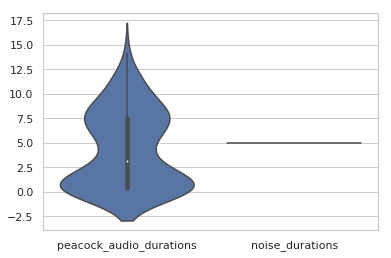

In [71]:
sns.set(style="whitegrid")
ax = sns.violinplot(data=dafr)

In [72]:
fn,features,final_labels,label,label1,label2 = parse_audio_files2(parent_dir,sub_dirs)

/opt/conda/lib/python3.6/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/opt/conda/lib/python3.6/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/opt/conda/lib/python3.6/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


In [73]:
final_labels.shape

(1242, 3)

In [74]:
from sklearn.preprocessing import MultiLabelBinarizer,LabelBinarizer
from numpy import argmax
from keras.utils import to_categorical
from keras import initializers

one_hot1 = LabelBinarizer()
# One-hot encode data
label_ = one_hot1.fit_transform(label)
label_1 = one_hot1.fit_transform(label1)

print(one_hot1.classes_)
print(label_)
print(label_1)

one_hot2 = MultiLabelBinarizer()
# One-hot encode data
label_2 = one_hot2.fit_transform(label2)
label__2 = to_categorical(label2)
print(label__2)
one_hot2.classes_

['0' '1']
[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]
[[1]
 [0]
 [1]
 ...
 [0]
 [0]
 [0]]
[[0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]


array(['0', '1', '2', '3', '4'], dtype=object)

In [75]:
print(label__2.shape)
print(label_1.shape)
print(label_.shape)
print(label_2.shape)

(1242, 5)
(1242, 1)
(1242, 1)
(1242, 5)


In [76]:
dafr_labels = pd.DataFrame()
dafr_labels["file_name"] = fn
dafr_labels["peacock"] = label_
dafr_labels["disturbance"] = label_1
#dafr_labels["single_peacock"] = [label__2]

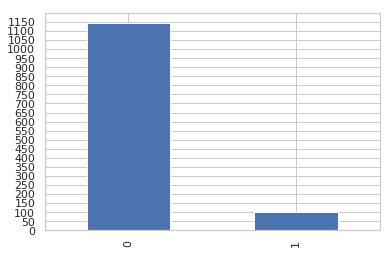

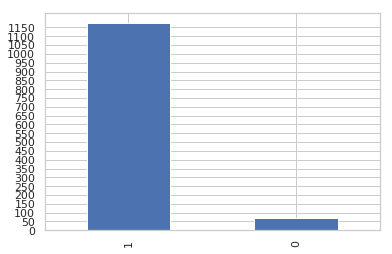

In [77]:
dafr_labels['peacock'].value_counts().plot(kind='bar')
            #,'disturbance','single_peacock']].plot(kind='bar')
#plt.xticks(np.arange(0, 51, 5)) 
plt.yticks(np.arange(0, 1200, 50)) 
plt.show()
dafr_labels['disturbance'].value_counts().plot(kind='bar')
plt.yticks(np.arange(0, 1200, 50)) 
plt.show()
#dafr_labels['single_peacock'].value_counts().plot(kind='bar')
#plt.yticks(np.arange(0, 1200, 25)) 
#plt.show()

In [78]:
pd.Series(label).value_counts()

0    1143
1      99
dtype: int64

In [79]:
pd.Series(label1).value_counts()

1    1174
0      68
dtype: int64

In [80]:
pd.Series(label2).value_counts()

0    1146
1      48
2      41
4       4
3       3
dtype: int64

In [81]:
#dafr_labels

# MLP keras 

In [82]:
import keras 
from keras.models import Sequential
from keras.layers import Dense, Activation,Flatten, Dropout, BatchNormalization

from sklearn.preprocessing import StandardScaler
#from keras import metrics
from sklearn.model_selection import train_test_split
#from sklearn.metrics import f1_score
#from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D
#from keras import regularizers, optimizer
import pandas as pd
import random
import tensorflow as tf

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
#from sklearn.preprocessing import LabelEncoder
#from sklearn.pipeline import Pipeline
from keras import backend as K


random.seed(42)
np.random.seed(42)
tf.set_random_seed(42)

my_init = initializers.glorot_uniform(seed=42)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [83]:
#from keras.layers.core import Flatten
X_train, X_test, y1_train, y1_test,y2_train,y2_test,y3_train,y3_test = train_test_split(features,
                                            label_,label_1,label__2, test_size=0.33, random_state=42)
#train_test_split(X, Y1, Y2, Y3, random_state = 42)

In [84]:
print(y3_train.shape)
print(y3_test.shape)

(832, 5)
(410, 5)


In [85]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [136]:
#plot_history(history)

## Multi output neural network

In [138]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred,average='macro')
    recall = recall_m(y_true, y_pred,average='macro')
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [139]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [141]:
#create the model
inn = Input(shape = (193,))
x = Sequential()(inn)
    # Adding the input layer and the first hidden layer
#x =
x = Dense(output_dim = 40, init = 'uniform', activation = 'relu', input_dim = 193)(x)
    # Adding the second hidden layer
#x = 
x=Dense(output_dim = 20, init = 'uniform', activation = 'relu')(x)
#x =
x= Dense(output_dim = 8, init = 'uniform', activation = 'relu')(x)
    # Adding the output layer
out1 =Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid')(x)
out2 =Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid')(x)
out3 =Dense(output_dim = 5, init = 'uniform', activation = 'softmax')(x)
    # Compiling Neural Network
model = Model(inputs=[inn], outputs=[out1, out2,out3])
#classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# compile the model
model.compile(optimizer='adam', loss=[f1_loss,f1_loss,f1_loss],
              metrics=[f1,f1,f1])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=193, units=40, kernel_initializer="uniform")`
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=20, kernel_initializer="uniform")`
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=8, kernel_initializer="uniform")`
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`
  del sys.path[0]
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 

In [142]:
class_weights = {0: 1.08377,
                1: 25.875,
                2: 30.3,
                3: 414,
                4: 310.5}

In [143]:
# fit the model
history = model.fit(X_train, [y1_train,y2_train,y3_train],
                    validation_split=0.3, epochs=100,batch_size = 10, verbose=1,class_weight=class_weights)

Train on 582 samples, validate on 250 samples
Epoch 1/100
582/582 [==============================] - 2s 3ms/step - loss: 1.9177 - dense_22_loss: 0.8688 - dense_23_loss: 0.1806 - dense_24_loss: 0.8683 - dense_22_f1: 0.1373 - dense_22_f1_1: 0.1373 - dense_22_f1_2: 0.1373 - dense_23_f1: 0.9702 - dense_23_f1_1: 0.9702 - dense_23_f1_2: 0.9702 - dense_24_f1: 0.0854 - dense_24_f1_1: 0.0854 - dense_24_f1_2: 0.0854 - val_loss: 1.7171 - val_dense_22_loss: 0.8762 - val_dense_23_loss: 0.0329 - val_dense_24_loss: 0.8079 - val_dense_22_f1: 0.1236 - val_dense_22_f1_1: 0.1236 - val_dense_22_f1_2: 0.1236 - val_dense_23_f1: 0.9673 - val_dense_23_f1_1: 0.9673 - val_dense_23_f1_2: 0.9673 - val_dense_24_f1: 0.1921 - val_dense_24_f1_1: 0.1921 - val_dense_24_f1_2: 0.1921
Epoch 2/100
582/582 [==============================] - 1s 879us/step - loss: 1.7025 - dense_22_loss: 0.8672 - dense_23_loss: 0.0271 - dense_24_loss: 0.8082 - dense_22_f1: 0.1327 - dense_22_f1_1: 0.1327 - dense_22_f1_2: 0.1327 - dense_23_f1: 

582/582 [==============================] - 1s 910us/step - loss: 1.2925 - dense_22_loss: 0.5234 - dense_23_loss: 0.0271 - dense_24_loss: 0.7421 - dense_22_f1: 0.4857 - dense_22_f1_1: 0.4857 - dense_22_f1_2: 0.4857 - dense_23_f1: 0.9730 - dense_23_f1_1: 0.9730 - dense_23_f1_2: 0.9730 - dense_24_f1: 0.2451 - dense_24_f1_1: 0.2451 - dense_24_f1_2: 0.2451 - val_loss: 1.3447 - val_dense_22_loss: 0.5739 - val_dense_23_loss: 0.0328 - val_dense_24_loss: 0.7380 - val_dense_22_f1: 0.4267 - val_dense_22_f1_1: 0.4267 - val_dense_22_f1_2: 0.4267 - val_dense_23_f1: 0.9673 - val_dense_23_f1_1: 0.9673 - val_dense_23_f1_2: 0.9673 - val_dense_24_f1: 0.2538 - val_dense_24_f1_1: 0.2538 - val_dense_24_f1_2: 0.2538
Epoch 24/100
582/582 [==============================] - 1s 917us/step - loss: 1.2223 - dense_22_loss: 0.4552 - dense_23_loss: 0.0270 - dense_24_loss: 0.7401 - dense_22_f1: 0.5424 - dense_22_f1_1: 0.5424 - dense_22_f1_2: 0.5424 - dense_23_f1: 0.9733 - dense_23_f1_1: 0.9733 - dense_23_f1_2: 0.9733 

582/582 [==============================] - 1s 897us/step - loss: 1.2728 - dense_22_loss: 0.5135 - dense_23_loss: 0.0267 - dense_24_loss: 0.7326 - dense_22_f1: 0.4868 - dense_22_f1_1: 0.4868 - dense_22_f1_2: 0.4868 - dense_23_f1: 0.9733 - dense_23_f1_1: 0.9733 - dense_23_f1_2: 0.9733 - dense_24_f1: 0.2628 - dense_24_f1_1: 0.2628 - dense_24_f1_2: 0.2628 - val_loss: 1.3456 - val_dense_22_loss: 0.5738 - val_dense_23_loss: 0.0327 - val_dense_24_loss: 0.7391 - val_dense_22_f1: 0.4267 - val_dense_22_f1_1: 0.4267 - val_dense_22_f1_2: 0.4267 - val_dense_23_f1: 0.9673 - val_dense_23_f1_1: 0.9673 - val_dense_23_f1_2: 0.9673 - val_dense_24_f1: 0.2405 - val_dense_24_f1_1: 0.2405 - val_dense_24_f1_2: 0.2405
Epoch 46/100
582/582 [==============================] - 1s 902us/step - loss: 1.1669 - dense_22_loss: 0.4215 - dense_23_loss: 0.0272 - dense_24_loss: 0.7182 - dense_22_f1: 0.5790 - dense_22_f1_1: 0.5790 - dense_22_f1_2: 0.5790 - dense_23_f1: 0.9728 - dense_23_f1_1: 0.9728 - dense_23_f1_2: 0.9728 

582/582 [==============================] - 1s 876us/step - loss: 1.2350 - dense_22_loss: 0.4877 - dense_23_loss: 0.0269 - dense_24_loss: 0.7203 - dense_22_f1: 0.5126 - dense_22_f1_1: 0.5126 - dense_22_f1_2: 0.5126 - dense_23_f1: 0.9731 - dense_23_f1_1: 0.9731 - dense_23_f1_2: 0.9731 - dense_24_f1: 0.2789 - dense_24_f1_1: 0.2789 - dense_24_f1_2: 0.2789 - val_loss: 1.3611 - val_dense_22_loss: 0.5823 - val_dense_23_loss: 0.0327 - val_dense_24_loss: 0.7460 - val_dense_22_f1: 0.4133 - val_dense_22_f1_1: 0.4133 - val_dense_22_f1_2: 0.4133 - val_dense_23_f1: 0.9673 - val_dense_23_f1_1: 0.9673 - val_dense_23_f1_2: 0.9673 - val_dense_24_f1: 0.2458 - val_dense_24_f1_1: 0.2458 - val_dense_24_f1_2: 0.2458
Epoch 68/100
582/582 [==============================] - 1s 933us/step - loss: 1.1740 - dense_22_loss: 0.4303 - dense_23_loss: 0.0266 - dense_24_loss: 0.7170 - dense_22_f1: 0.5699 - dense_22_f1_1: 0.5699 - dense_22_f1_2: 0.5699 - dense_23_f1: 0.9734 - dense_23_f1_1: 0.9734 - dense_23_f1_2: 0.9734 

582/582 [==============================] - 1s 913us/step - loss: 1.2147 - dense_22_loss: 0.4633 - dense_23_loss: 0.0269 - dense_24_loss: 0.7244 - dense_22_f1: 0.5384 - dense_22_f1_1: 0.5384 - dense_22_f1_2: 0.5384 - dense_23_f1: 0.9731 - dense_23_f1_1: 0.9731 - dense_23_f1_2: 0.9731 - dense_24_f1: 0.2617 - dense_24_f1_1: 0.2617 - dense_24_f1_2: 0.2617 - val_loss: 1.3570 - val_dense_22_loss: 0.5791 - val_dense_23_loss: 0.0327 - val_dense_24_loss: 0.7451 - val_dense_22_f1: 0.4267 - val_dense_22_f1_1: 0.4267 - val_dense_22_f1_2: 0.4267 - val_dense_23_f1: 0.9673 - val_dense_23_f1_1: 0.9673 - val_dense_23_f1_2: 0.9673 - val_dense_24_f1: 0.2245 - val_dense_24_f1_1: 0.2245 - val_dense_24_f1_2: 0.2245
Epoch 90/100
582/582 [==============================] - 1s 881us/step - loss: 1.2217 - dense_22_loss: 0.4655 - dense_23_loss: 0.0269 - dense_24_loss: 0.7293 - dense_22_f1: 0.5349 - dense_22_f1_1: 0.5349 - dense_22_f1_2: 0.5349 - dense_23_f1: 0.9731 - dense_23_f1_1: 0.9731 - dense_23_f1_2: 0.9731 

In [144]:
# evaluate the model
f1score = model.evaluate(X_test, [y1_test,y2_test,y3_test])
#classifier =KerasClassifier(build_fn=making_model(193), epochs=100, batch_size=10, verbose=0)

410/410 [==============================] - 0s 302us/step


In [145]:
f1score

[1.096578829172181,
 0.3463360582909933,
 0.031226713773680897,
 0.7190160524554369,
 0.6498548362313248,
 0.6498548362313248,
 0.6498548362313248,
 0.9687837088980326,
 0.9687837088980326,
 0.9687837088980326,
 0.2589311569202237,
 0.2589311569202237,
 0.2589311569202237]

In [146]:
yy1,yy2,yy3 = model.predict(X_test)

In [147]:
shape = yy3.shape
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        if yy3[i, j] >= 0.5:
            yy3[i, j] = 1
        else:
            yy3[i, j] = 0
for i in range(0, shape[0]):
        if yy2[i, 0] >= 0.5:
            yy2[i, 0] = 1
        else:
            yy2[i, 0] = 0
for i in range(0, shape[0]):
        if yy1[i, 0] >= 0.5:
            yy1[i, 0] = 1
        else:
            yy1[i, 0] = 0     


In [148]:
res_pred=np.empty(shape=(len(yy3),1),dtype=int)
res_ex = np.empty(shape=(len(yy3),1),dtype=int)

In [149]:
for i in range(len(yy3)):
    res_pred[i] = argmax(yy3[i])
    res_ex[i] = argmax(y3_test[i])
    print(argmax(yy3[i]))
    print(y3_test[i])
    print("--------------------------------------------")

0
[1. 0. 0. 0. 0.]
--------------------------------------------
0
[1. 0. 0. 0. 0.]
--------------------------------------------
0
[1. 0. 0. 0. 0.]
--------------------------------------------
0
[1. 0. 0. 0. 0.]
--------------------------------------------
0
[1. 0. 0. 0. 0.]
--------------------------------------------
0
[1. 0. 0. 0. 0.]
--------------------------------------------
0
[1. 0. 0. 0. 0.]
--------------------------------------------
0
[1. 0. 0. 0. 0.]
--------------------------------------------
0
[1. 0. 0. 0. 0.]
--------------------------------------------
0
[1. 0. 0. 0. 0.]
--------------------------------------------
0
[1. 0. 0. 0. 0.]
--------------------------------------------
0
[1. 0. 0. 0. 0.]
--------------------------------------------
0
[1. 0. 0. 0. 0.]
--------------------------------------------
0
[1. 0. 0. 0. 0.]
--------------------------------------------
0
[0. 0. 1. 0. 0.]
--------------------------------------------
0
[0. 1. 0. 0. 0.]
---------------------

In [150]:
confusion_matrix(res_ex,res_pred)

array([[366,   3,   6,   0,   0],
       [  4,   2,  10,   0,   0],
       [  3,   5,   7,   0,   0],
       [  2,   0,   0,   0,   0],
       [  1,   0,   1,   0,   0]])

In [133]:
print(f1_score(res_ex,res_pred,average='micro'))
print(precision_score(res_ex,res_pred,average='micro'))
print(recall_score(res_ex,res_pred,average='micro'))

0.9243902439024391
0.9243902439024391
0.9243902439024391


In [137]:
accuracy_score(res_ex,res_pred)

0.9243902439024391

In [134]:
print(f1_score(res_ex,res_pred,average='macro'))
print(precision_score(res_ex,res_pred,average='macro'))
print(recall_score(res_ex,res_pred,average='macro'))

0.37551564844692475
0.398125
0.3635333333333334


In [1]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,multilabel_confusion_matrix

ImportError: cannot import name 'multilabel_confusion_matrix' from 'sklearn.metrics' (C:\Users\sathya sravya\Anaconda3\lib\site-packages\sklearn\metrics\__init__.py)

In [ ]:
from imblearn.keras import BalancedBatchGenerator
from sklearn.metrics import roc_auc_score

def fit_predict_balanced_model(X_train, y_train, X_test, y_test):
    model = classifier
    training_generator = BalancedBatchGenerator(X_train, y_train)
    model.fit_generator(generator=training_generator,epochs=100,verbose=1)
    y_pred = model.predict_proba(X_test)
    print(classification_report(y_test, y_pred))
    return roc_auc_score(y_test, y_pred)
res = fit_predict_balanced_model(X_train, y_train, X_test, y_test)

In [ ]:
classifier

In [ ]:
model

In [ ]:
# Fitting our model 
import eli5
from eli5.sklearn import PermutationImportance

history=model.fit(X_train, y_train,validation_data=(X_test, y_test),nb_epoch = 100)
#history=classifier.fit(X,y,validation_data=(X_test, y_test), batch_size = 10, nb_epoch = 100)
#acc = []
# Predicting the Test set results

In [ ]:
y_pred = model.predict(X_test)
#print(pd.Series(y_pred[:,0]).value_counts())
#print(pd.Series(y_pred[:,1]).value_counts())
#print(pd.Series(y_pred[:,2]).value_counts())